# **Image Captioning with Deep Learning**

In [26]:
!pip install rouge-score

  Preparing metadata (setup.py) ... done
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24935 sha256=f10b2f9cb0c866dec873272e5cb65d25757f827720ceae9ef614b3947bf16a34
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge-score


#  **Import Required Libraries**

In [27]:
import numpy as np
import pandas as pd
import os
import pickle
import tensorflow as tf
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import Sequence, to_categorical
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, AdditiveAttention, TimeDistributed, Bidirectional
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from transformers import BlipProcessor, BlipForConditionalGeneration
import cv2
import pickle
from textwrap import wrap
import warnings
import seaborn as sns
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor
from rouge_score import rouge_scorer

plt.rcParams['font.size'] = 12
sns.set_style("dark")
warnings.filterwarnings('ignore')

# **Load Dataset and Preprocessing**

In [28]:
# Load Dataset
image_path = '../input/flickr8k/Images'
data = pd.read_csv("../input/flickr8k/captions.txt")
data.head()

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...


In [29]:
data['image'] = data['image'].apply(lambda x: x.split("#")[0])

In [30]:
def readImage(path,img_size=224):
    img = load_img(path,color_mode='rgb',target_size=(img_size,img_size))
    img = img_to_array(img)
    img = img/255.
    
    return img

def display_images(temp_df):
    temp_df = temp_df.reset_index(drop=True)
    plt.figure(figsize = (20 , 20))
    n = 0
    for i in range(15):
        n+=1
        plt.subplot(5 , 5, n)
        plt.subplots_adjust(hspace = 0.7, wspace = 0.3)
        image = readImage(f"../input/flickr8k/Images/{temp_df.image[i]}")
        plt.imshow(image)
        plt.title("\n".join(wrap(temp_df.caption[i], 20)))
        plt.axis("off")

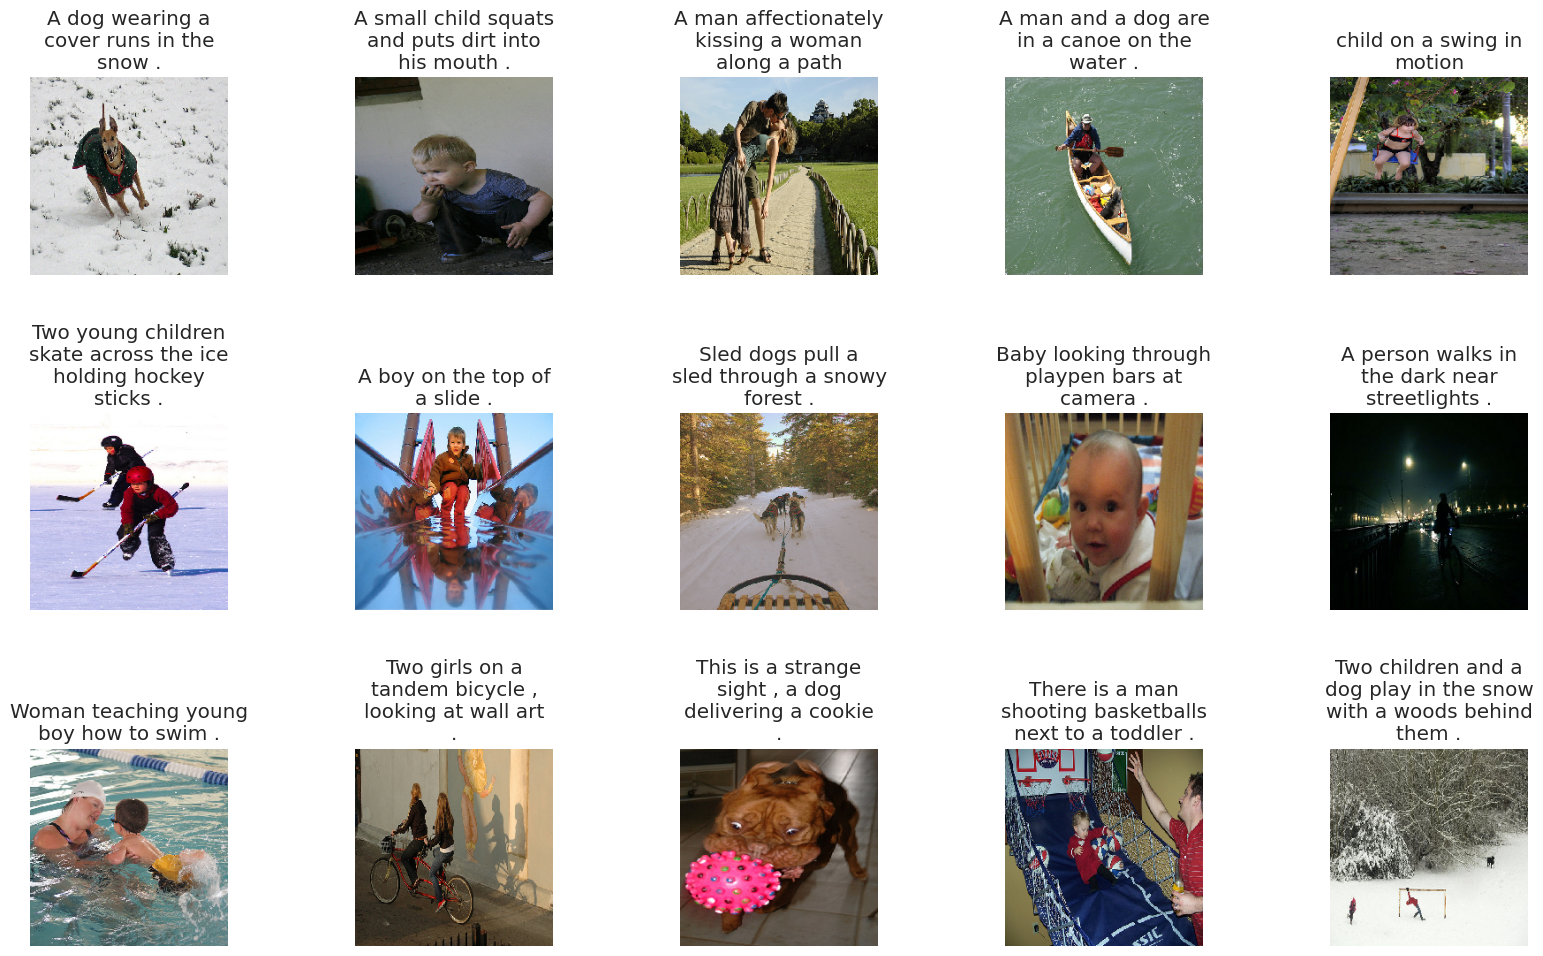

In [31]:
display_images(data.sample(15))

In [32]:
data.columns = ['image', 'caption']
data['caption'] = 'startseq ' + data['caption'] + ' endseq'
unique_images = data['image'].unique()

In [33]:
def text_preprocessing(data):
    data['caption'] = data['caption'].apply(lambda x: x.lower())
    data['caption'] = data['caption'].apply(lambda x: x.replace("[^A-Za-z]",""))
    data['caption'] = data['caption'].apply(lambda x: x.replace("\s+"," "))
    data['caption'] = data['caption'].apply(lambda x: " ".join([word for word in x.split() if len(word)>1]))
    data['caption'] = "startseq "+data['caption']+" endseq"
    return data

In [34]:
data = text_preprocessing(data)
captions = data['caption'].tolist()
captions[:10]

['startseq startseq child in pink dress is climbing up set of stairs in an entry way endseq endseq',
 'startseq startseq girl going into wooden building endseq endseq',
 'startseq startseq little girl climbing into wooden playhouse endseq endseq',
 'startseq startseq little girl climbing the stairs to her playhouse endseq endseq',
 'startseq startseq little girl in pink dress going into wooden cabin endseq endseq',
 'startseq startseq black dog and spotted dog are fighting endseq endseq',
 'startseq startseq black dog and tri-colored dog playing with each other on the road endseq endseq',
 'startseq startseq black dog and white dog with brown spots are staring at each other in the street endseq endseq',
 'startseq startseq two dogs of different breeds looking at each other on the road endseq endseq',
 'startseq startseq two dogs on pavement moving toward each other endseq endseq']

# **Tokenization and Sequence Padding**

In [43]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(captions)
vocab_size = len(tokenizer.word_index) + 1
max_length = max(len(caption.split()) for caption in captions)
embedding_dim = 256
units = 512

images = data['image'].unique().tolist()
nimages = len(images)

split_index = round(0.85*nimages)
train_images = images[:split_index]
val_images = images[split_index:]

train = data[data['image'].isin(train_images)]
test = data[data['image'].isin(val_images)]

train.reset_index(inplace=True,drop=True)
test.reset_index(inplace=True,drop=True)

tokenizer.texts_to_sequences([captions[1]])[0]

[1, 1, 18, 315, 63, 195, 116, 2, 2]

# **Feature Extraction**

In [36]:
# Feature Extraction using InceptionV3
base_model = InceptionV3(weights='imagenet')
cnn_model = Model(inputs=base_model.input, outputs=base_model.get_layer('avg_pool').output)

def preprocess_image(img_path):
    img = load_img(img_path, target_size=(299, 299))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = preprocess_input(img)
    return img

def extract_features_batch(image_list, batch_size=32):
    features = {}
    for i in range(0, len(image_list), batch_size):
        batch_images = image_list[i:i+batch_size]
        img_paths = [os.path.join(image_path, img) for img in batch_images]
        images = np.vstack([preprocess_image(img) for img in img_paths])
        batch_features = cnn_model.predict(images, verbose=1)
        for j, img in enumerate(batch_images):
            features[img] = batch_features[j]
    return features

image_features = extract_features_batch(unique_images)
with open('image_features.pkl', 'wb') as f:
    pickle.dump(image_features, f)

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━

In [37]:
# Load extracted image features
with open('image_features.pkl', 'rb') as f:
    features = pickle.load(f)

# **Data Generation**

In [38]:
# Custom Data Generator
class CustomDataGenerator(Sequence):
    def __init__(self, df, X_col, y_col, batch_size, tokenizer, vocab_size, max_length, features, shuffle=True):
        self.df = df.copy()
        self.X_col = X_col  # Image file names
        self.y_col = y_col  # Captions
        self.batch_size = batch_size
        self.tokenizer = tokenizer
        self.vocab_size = vocab_size
        self.max_length = max_length
        self.features = features  # Dictionary containing image features
        self.shuffle = shuffle
        self.n = len(self.df)
    
    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)
    
    def __len__(self):
        return self.n // self.batch_size
    
    def __getitem__(self, index):
        batch = self.df.iloc[index * self.batch_size:(index + 1) * self.batch_size, :]
        X1, X2, y = self.__get_data(batch)
        return (X1, X2), y
    
    def __get_data(self, batch):
        X1, X2, y = list(), list(), list()
        images = batch[self.X_col].tolist()
        for image in images:
            feature = np.array(self.features[image])
            captions = batch.loc[batch[self.X_col] == image, self.y_col].tolist()
            for caption in captions:
                seq = self.tokenizer.texts_to_sequences([caption])[0]
                for i in range(1, len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=self.max_length)[0]
                    out_seq = to_categorical([out_seq], num_classes=self.vocab_size)[0]
                    X1.append(feature)
                    X2.append(in_seq)
                    y.append(out_seq)
        return np.array(X1), np.array(X2), np.array(y)

# **Modeling**

In [41]:
# Define CNN+LSTM with Attention
class CNN_LSTM_Attention_Model(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, units, max_length):
        super(CNN_LSTM_Attention_Model, self).__init__()
        self.units = units
        
        self.feature_extractor = Dense(units, activation='relu')  # Linear layer to transform CNN features
        self.embedding = Embedding(vocab_size, embedding_dim, mask_zero=True)
        self.lstm = Bidirectional(LSTM(units, return_sequences=True, return_state=True, recurrent_initializer='glorot_uniform'))
        self.attention = AdditiveAttention()
        self.fc = TimeDistributed(Dense(vocab_size, activation='softmax'))
    
    def call(self, img_features, seq_input, hidden_state):
        img_features = self.feature_extractor(img_features)
        seq_embedded = self.embedding(seq_input)
        
        # Attention mechanism
        context_vector = self.attention([seq_embedded, img_features])
        lstm_input = tf.concat([tf.expand_dims(context_vector, 1), seq_embedded], axis=-1)
        lstm_output, forward_h, forward_c, backward_h, backward_c = self.lstm(lstm_input, initial_state=hidden_state)
        
        output = self.fc(lstm_output)
        return output, forward_h, forward_c, backward_h, backward_c

    def initialize_hidden_state(self, batch_size):
        return [tf.zeros((batch_size, self.units)) for _ in range(4)]

In [44]:
# Initialize model
model = CNN_LSTM_Attention_Model(vocab_size, embedding_dim, units, max_length)
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False, reduction='none')

In [46]:
# Loss function
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss = loss_object(real, pred)
    mask = tf.cast(mask, dtype=loss.dtype)
    loss *= mask
    return tf.reduce_mean(loss)

In [47]:
# Training step function
@tf.function
def train_step(img_tensor, target_seq):
    batch_size = img_tensor.shape[0]
    hidden = model.initialize_hidden_state(batch_size)
    
    with tf.GradientTape() as tape:
        predictions, _, _, _, _ = model(img_tensor, target_seq[:, :-1], hidden)
        loss = loss_function(target_seq[:, 1:], predictions)
    
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss

In [58]:
# Callbacks
# Correct file extension for TensorFlow 2.x
model_name = "cnn_lstm_attention_model.keras"
checkpoint = ModelCheckpoint(model_name, monitor="val_loss", mode="min", save_best_only=True, verbose=1)
earlystopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, restore_best_weights=True)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience=3, verbose=1, factor=0.2, min_lr=1e-8)

# Model Training
history = caption_model.fit(
        train_generator,
        epochs=5,
        validation_data=validation_generator,
        callbacks=[checkpoint, earlystopping, learning_rate_reduction]
)

Epoch 1/5
1073/1074 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 2.9442
Epoch 1: val_loss improved from inf to 3.04423, saving model to cnn_lstm_attention_model.keras
1074/1074 ━━━━━━━━━━━━━━━━━━━━ 62s 57ms/step - loss: 2.9442 - val_loss: 3.0442 - learning_rate: 0.0010
Epoch 2/5
1074/1074 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 2.8703
Epoch 2: val_loss did not improve from 3.04423
1074/1074 ━━━━━━━━━━━━━━━━━━━━ 62s 58ms/step - loss: 2.8703 - val_loss: 3.0539 - learning_rate: 0.0010
Epoch 3/5
1073/1074 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 2.8319
Epoch 3: val_loss did not improve from 3.04423
1074/1074 ━━━━━━━━━━━━━━━━━━━━ 61s 56ms/step - loss: 2.8319 - val_loss: 3.0450 - learning_rate: 0.0010
Epoch 4/5
1073/1074 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 2.7849
Epoch 4: val_loss did not improve from 3.04423

Epoch 4: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
1074/1074 ━━━━━━━━━━━━━━━━━━━━ 61s 57ms/step - loss: 2.7849 - val_loss: 3.0574 - learning_rate: 0.001

In [ ]:
print("Feature shape:", next(iter(features.values())).shape)

# **Genertaing and Predicitng the captions**

In [60]:
# Function to generate caption
def generate_caption(image_path, tokenizer, max_length, model, features):
    image = os.path.basename(image_path)
    feature = features[image][0]
    in_text = '<start>'
    for _ in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = model.predict([np.array([feature]), np.array(sequence)], verbose=0)
        yhat = np.argmax(yhat)
        word = tokenizer.index_word.get(yhat, '')
        if word is None or word == '<end>':
            break
        in_text += ' ' + word
    return in_text.replace('<start>', '').strip()

In [61]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
import cv2
import numpy as np
import pickle
import os

# Load pre-trained InceptionV3 for feature extraction
image_model = InceptionV3(weights='imagenet')
image_model = tf.keras.Model(image_model.input, image_model.layers[-2].output)

# Load existing extracted features
with open('image_features.pkl', 'rb') as f:
    features = pickle.load(f)

def extract_features(image_path):
    """Extract features for a new image using InceptionV3."""
    image = cv2.imread(image_path)
    image = cv2.resize(image, (299, 299))  # Resize to match InceptionV3 input size
    image = preprocess_input(np.expand_dims(image, axis=0))  # Normalize
    
    feature = image_model.predict(image)
    return feature

def generate_caption(image_path, tokenizer, max_length, model, features):
    """Generate a caption for a given image."""
    image_name = os.path.basename(image_path)

    # Extract features if the image is new
    if image_name not in features:
        print("Extracting features for new image...")
        features[image_name] = extract_features(image_path)
        with open('image_features.pkl', 'wb') as f:
            pickle.dump(features, f)  # Save updated features

    feature = features[image_name][0]
    in_text = '<start>'
    
    for _ in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)
        
        yhat = model.predict([np.array([feature]), np.array(sequence)], verbose=0)
        yhat = np.argmax(yhat)
        word = tokenizer.index_word.get(yhat, '')
        
        if word is None or word == '<end>':
            break
            
        in_text += ' ' + word

    return in_text.replace('<start>', '').strip()

# Path to new image
sample_image_path = "/kaggle/input/sample-image/young-boy-playing-with-a-dog-in-the-park-photo.jpg"  # Update with actual path

# Generate caption
caption = generate_caption(sample_image_path, tokenizer, max_length, caption_model, features)
print("Predicted Caption:", caption)

Extracting features for new image...
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
Predicted Caption: startseq dog is running through the grass endseq endseq endseq endseq endseq endseq endseq endseq endseq endseq endseq endseq endseq endseq endseq endseq endseq endseq endseq endseq endseq endseq endseq endseq endseq endseq endseq endseq endseq


In [62]:
# Hugging Face BLIP Model
from transformers import BlipProcessor, BlipForConditionalGeneration

processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
model_blip = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base")

def blip_generate_caption(image_path, model, processor):
    img = load_img(image_path, target_size=(256, 256))
    inputs = processor(img, return_tensors="pt")
    output = model.generate(**inputs)
    return processor.decode(output[0], skip_special_tokens=True)

In [63]:
from PIL import Image
 
# Predict caption for a sample unseen image using both models
sample_image_path = "/kaggle/input/sample-image/young-boy-playing-with-a-dog-in-the-park-photo.jpg"  # Update with actual image path
caption_lstm = generate_caption(sample_image_path, tokenizer, max_length, caption_model, features)
caption_blip = blip_generate_caption(sample_image_path, model_blip, processor)  # ✅ Pass model and processor
 
print("Predicted Caption (LSTM Model):", caption_lstm)
print("Predicted Caption (BLIP Model):", caption_blip)

Predicted Caption (LSTM Model): startseq dog is running through the grass endseq endseq endseq endseq endseq endseq endseq endseq endseq endseq endseq endseq endseq endseq endseq endseq endseq endseq endseq endseq endseq endseq endseq endseq endseq endseq endseq endseq endseq
Predicted Caption (BLIP Model): a boy playing with a dog


# **Evaluation**

In [64]:
!pip install nltk rouge-score

In [65]:
import nltk
import numpy as np
from nltk.translate.bleu_score import corpus_bleu, sentence_bleu, SmoothingFunction
from rouge_score import rouge_scorer

In [66]:
# BLEU Score Calculation
def calculate_bleu_scores(references, hypotheses):
    """
    Computes BLEU-1 to BLEU-4 scores for generated captions.
    
    :param references: List of lists containing reference captions (ground truth)
    :param hypotheses: List containing predicted captions
    :return: BLEU-1, BLEU-2, BLEU-3, BLEU-4 scores
    """
    smoothie = SmoothingFunction().method1  # Smoothing to handle small datasets

    bleu1 = corpus_bleu(references, hypotheses, weights=(1.0, 0, 0, 0), smoothing_function=smoothie)
    bleu2 = corpus_bleu(references, hypotheses, weights=(0.5, 0.5, 0, 0), smoothing_function=smoothie)
    bleu3 = corpus_bleu(references, hypotheses, weights=(0.33, 0.33, 0.33, 0), smoothing_function=smoothie)
    bleu4 = corpus_bleu(references, hypotheses, weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=smoothie)
    
    return {"BLEU-1": bleu1, "BLEU-2": bleu2, "BLEU-3": bleu3, "BLEU-4": bleu4}

# ROUGE Score Calculation
def calculate_rouge_scores(references, hypotheses):
    """
    Computes ROUGE-L score for generated captions.
    
    :param references: List of reference captions
    :param hypotheses: List of generated captions
    :return: ROUGE-L score
    """
    scorer = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)
    rouge_l_scores = [scorer.score(ref, hyp)['rougeL'].fmeasure for ref, hyp in zip(references, hypotheses)]
    
    return {"ROUGE-L": np.mean(rouge_l_scores)}

In [68]:
from PIL import Image

# Sample unseen image path (Update with actual image path)
sample_image_path = "/kaggle/input/sample-image/young-boy-playing-with-a-dog-in-the-park-photo.jpg"

# Predict captions using both models
caption_lstm = generate_caption(sample_image_path, tokenizer, max_length, caption_model, features)
caption_blip = blip_generate_caption(sample_image_path, model_blip, processor)  # ✅ Pass model and processor

# Print predicted captions
print("Predicted Caption (LSTM Model):", caption_lstm)
print("Predicted Caption (BLIP Model):", caption_blip)

# Define reference captions for evaluation (Ground truth captions)
reference_captions = [
    ["a young boy is playing with a dog", "a child is running with his pet"],
]  # Add more reference captions if available

# Compute BLEU and ROUGE scores for both models
bleu_lstm = calculate_bleu_scores(reference_captions, [caption_lstm])
rouge_lstm = calculate_rouge_scores([" ".join(ref) for ref in reference_captions], [caption_lstm])

bleu_blip = calculate_bleu_scores(reference_captions, [caption_blip])
rouge_blip = calculate_rouge_scores([" ".join(ref) for ref in reference_captions], [caption_blip])

# Print Evaluation Metrics
print("\nEvaluation Metrics:")
print("🔹 LSTM Model BLEU Score:", bleu_lstm)
print("🔹 LSTM Model ROUGE Score:", rouge_lstm)
print("🔹 BLIP Model BLEU Score:", bleu_blip)
print("🔹 BLIP Model ROUGE Score:", rouge_blip)


Predicted Caption (LSTM Model): startseq dog is running through the grass endseq endseq endseq endseq endseq endseq endseq endseq endseq endseq endseq endseq endseq endseq endseq endseq endseq endseq endseq endseq endseq endseq endseq endseq endseq endseq endseq endseq endseq
Predicted Caption (BLIP Model): a boy playing with a dog

Evaluation Metrics:
🔹 LSTM Model BLEU Score: {'BLEU-1': 0.12295081967213112, 'BLEU-2': 0.09804814417003115, 'BLEU-3': 0.08013472111139126, 'BLEU-4': 0.06668941354207658}
🔹 LSTM Model ROUGE Score: {'ROUGE-L': 0.11764705882352941}
🔹 BLIP Model BLEU Score: {'BLEU-1': 0.7470175003104325, 'BLEU-2': 0.7470175003104325, 'BLEU-3': 0.7238876877825431, 'BLEU-4': 0.70185259083299}
🔹 BLIP Model ROUGE Score: {'ROUGE-L': 0.5714285714285715}
